### Import statements

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm

from datetime import datetime, timedelta, tzinfo

from scipy.stats import norm, linregress, f_oneway

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans

In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('.'), '..', 'lib'))

import strategies
from calculations import price_calcs

### Import data

In [3]:
with pd.HDFStore("data.hdf", mode="r") as hdf_store:
    bars = hdf_store["bars"]
    fundamentals = hdf_store["fundamentals"]
    positions = hdf_store["positions"]
indices = ["SPY", "QQQ", "DIA", "IWM"]
snp = bars.drop(indices, axis=1, level=0)
indices = bars.loc[:, (indices, slice(None))].copy()

### Function Definitions

In [4]:
def scaled_price_change(prices):
    """Calculate the scaled total price change over a range of
    window sizes.
    (S dP - avg(S dP)) / <var(S dP)> where S is sum over some range t

    Arguments:
    prices (pandas DataFrame): Price as a function of time, oldest
    data at position zero, and most current data at end of series.

    returns (pandas DataFrame)
    scaled price change (index position corresponds to time frame.
    """
    dP = prices.pct_change().iloc[1:][::-1]

    max_window_length = int(len(prices) / 4)
    scaled_dP = pd.DataFrame(index=range(1, max_window_length),
                             columns=prices.columns)

    for i in range(1, max_window_length):
        avg = dP.rolling(window=i, axis=0).sum().mean()
        std = dP.rolling(window=i, axis=0).sum().std()
        scaled_dP.loc[i] = (dP.iloc[:i].mean() - avg) / std

    return scaled_dP

### One off analysis

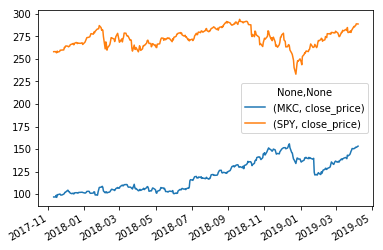

In [20]:
bars.loc[:, (["MKC", "SPY"], "close_price")].plot()

### Dividend Trades

In [5]:
dividend_dates = []
for f in fundamentals['dividendDate']:
    try:
        dividend_dates.append(datetime.strptime(f.split(" ")[0], "%Y-%m-%d"))
    except AttributeError:
        dividend_dates.append(None)
dividend_dates = pd.Series(dividend_dates)

In [6]:
start_date = datetime.today() + timedelta(days=2)
end_date = start_date + timedelta(days=10)
fmt = "%Y-%m-%d"
start_date = datetime.strftime(start_date, fmt)
end_date = datetime.strftime(end_date, fmt)
dividends = fundamentals[(fundamentals['dividendDate'] > start_date) & 
                         (fundamentals['dividendDate'] < end_date) & 
                         (fundamentals['dividendYield'] > 1.0)].sort_values(by='dividendDate')

In [7]:
dividend_rank = {}
today = datetime.today()
for r in dividends.iterrows():
    days = (datetime.strptime(dividends.loc[r[0], "dividendDate"].split(" ")[0], "%Y-%m-%d") - today).days
    dividend_rank[r[0]] = r[1].dividendYield - days/10.
dividend_rank = pd.Series(dividend_rank).sort_values()

In [8]:
dividend_rank

APH     0.46
CERN    0.52
FLS     0.84
ALLE    1.01
FIS     1.06
AMT     1.16
ICE     1.24
CB      1.25
IFF     1.26
PHM     1.32
DVN     1.33
MSI     1.42
BR      1.45
CINF    1.68
ADP     1.87
NDAQ    1.97
ALB     2.22
FRT     2.32
AIG     2.41
VIAB    2.56
MRK     2.58
NTRS    2.71
XEL     2.73
GRMN    2.78
DTE     2.81
TROW    2.91
KO      3.16
EXR     3.26
OMC     3.26
CCI     3.36
PKG     3.45
DLR     3.57
EMN     3.62
CMA     3.79
GILD    3.95
WU      4.02
HBAN    4.23
LEG     4.41
STX     5.42
MO      6.42
M       7.24
IRM     7.77
dtype: float64

### Cluster / Industry Analysis

Define a set of stocks for each cluster (i.e. sector) type.

In [9]:
dP = bars.loc[:, (slice(None), 'close_price')].pct_change().iloc[1:].dropna(axis=1)
dP.columns = dP.columns.get_level_values(0)
valuations = ["dividendYield", "currentRatio", "quickRatio", "peRatio", "pegRatio", "pbRatio", "pcfRatio", "prRatio", "totalDebtToCapital", "totalDebtToEquity"]
INDUSTRIES = { 
    "BANK": "C, JPM, BAC, WFC, AIG, GS",
    "PETROLEUM": "XOM, COP, FANG, OXY, HES, MPC, SLB, HAL",
    "ENERGY": "ED, WEC, ES, SO",
    "REALESTATE": "PSA, ARE, DRE, O, KIM",
    "RETAIL": "ROST, HD, LOW, WMT, PVH, RL, TIF, TJX, TGT, M",
    "SEMICONDUCTOR": "MU, AMD, AMAT, INTC, LRCX, NVDA, WDC, STX",
    "PHARMACEUTICAL": "PFE, ABT, ABBV, MRK, LLY, BMY, NOV, BIIB, JNJ, AMGN",
    "INDUSTRIAL": "CAT, MMM, DWDP, PPG, GE, UTX, HON, FAST, EMR, GWW, GLW",
    "TECHNOLOGY": "AMZN, GOOGL, MSFT, IBM, FB, PAYX, NFLX, TWTR, AAPL, PYPL, EXPE",
    "DURABLE": "CL, CLX, MCD, DLTR, ULTA, SJM, KR, WM, IFF",
    "MEDICALDEVICE": "ABT, ISRG, EW, BAX, BSX",
}
for k, v in INDUSTRIES.items():
    INDUSTRIES[k] = v.split(", ")

Cluster the stocks based on the projection of rolling price changes onto a principal components.
The number of clusters can be set to get more subsets. However, increasing the number of clusters will make the clusters less independent.
The window size of the rolling average can be set. This could be useful for different trading durations.

In [10]:
NUMBER_CLUSTERS = 11
WINDOW_SIZE = 1
X = dP.rolling(window=WINDOW_SIZE).mean().iloc[10:]
X.columns = X.columns.get_level_values(0)
X = X.subtract(X.loc[:, "SPY"], axis=0)
X = X.apply(lambda x: (x - x.mean()) / x.std()).dropna(axis=1)
n_components = 10
pca = PCA(n_components=n_components).fit(X)
loadings = pd.DataFrame(index=X.index,
                        columns=range(1, n_components+1),
                        data=pca.transform(X))

norm_loadings = loadings.apply(lambda x: x/np.sqrt(np.dot(x, x)))
proj = pd.DataFrame(index=range(1, n_components+1),
                    columns=X.columns,
                    data=np.dot(norm_loadings.T.values, X.values))#

#clustering = DBSCAN(eps=1, min_samples=2).fit(proj.T)
clustering = KMeans(n_clusters=NUMBER_CLUSTERS).fit(proj.T)
data = fundamentals.loc[:, valuations].join(pd.Series(index=X.columns, name='cluster', data=clustering.labels_)).dropna(axis=0)
data.cluster = data.cluster.astype(int)

Map the clusters to a sector by finding what cluster is most common for the stocks in each sector to belong.

In [11]:
#Map the clusters to industry categories used a subset of stocks defined above.
data["category"] = "UNCLASSIFIED"
for k, v in INDUSTRIES.items():
    try:
        cluster_label = int(data.loc[v]['cluster'].mode())
        data.loc[data.cluster==cluster_label, "category"] = k
    except KeyError:
        print("Error in category {}".format(k))
    except TypeError:
        cluster_label = int(data.loc[v]['cluster'].mode()[0])
        data.loc[data.cluster==cluster_label, "category"] = k

/home/brent/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


Tabulate some fundamental data for each sector.

In [12]:
temp = {}
for g in data.groupby('category').groups.items():
    temp[g[0]] = data.loc[g[1], :].mean(axis=0)
analysis = pd.DataFrame.from_dict(temp).T.drop("cluster", axis=1)

scaled_analysis = pd.DataFrame(index=analysis.index, columns=analysis.columns, data=preprocessing.MinMaxScaler().fit_transform(analysis.values))
industry_rank = scaled_analysis.iloc[:, :3].sum(axis=1) - scaled_analysis.iloc[:, 3:].sum(axis=1)

analysis

,dividendYield,currentRatio,quickRatio,peRatio,pegRatio,pbRatio,pcfRatio,prRatio,totalDebtToCapital,totalDebtToEquity
BANK,2.801395,0.000000,0.000000,11.139772,0.609666,1.492315,8.730910,2.490857,21.209302,187.534884
ENERGY,3.049302,0.765330,0.560554,40.407586,2.697262,4.043589,15.198382,3.273905,64.372093,173.720930
INDUSTRIAL,2.116622,1.651249,1.089348,17.929071,0.553127,25.090493,12.332900,1.797045,49.148649,278.189189
PETROLEUM,3.212759,1.292606,0.873975,26.466233,0.199303,1.578219,7.519611,1.856028,32.931034,62.620690
PHARMACEUTICAL,1.126176,1.878688,1.481057,29.631964,2.054031,18.866229,21.174166,4.041318,47.735294,148.176471
REALESTATE,3.836800,0.112958,0.000000,43.090700,1.623403,4.360896,17.039016,9.654787,51.440000,163.000000
RETAIL,2.104655,1.368056,0.671120,23.598184,1.078211,6.265996,12.857860,1.493614,41.137931,135.896552
SEMICONDUCTOR,2.598333,2.647732,2.038544,23.561009,0.319218,5.463077,11.337565,2.899057,48.750000,139.750000
TECHNOLOGY,0.217000,2.773974,1.773571,46.698260,1.464120,10.977113,49.938647,9.094671,23.300000,35.800000
UNCLASSIFIED,1.906777,1.467136,0.855336,26.116543,1.041796,10.061640,15.689432,3.372608,52.801653,186.661157


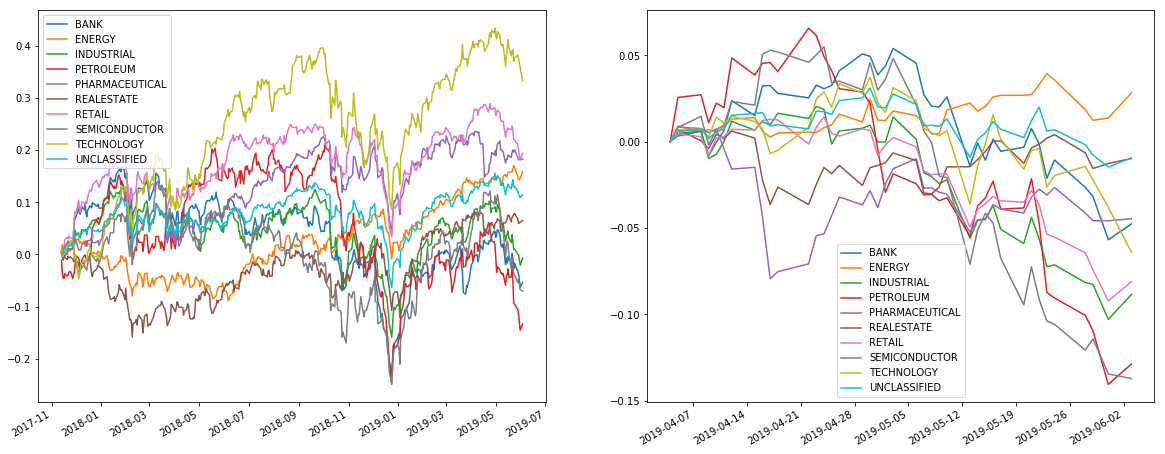

In [13]:
temp = dP[data.index]
SdP_mean = {}
for cat in analysis.index:
    SdP_mean[cat] = temp.loc[:, data.category==cat].mean(axis=1).cumsum().values
SdP_mean = pd.DataFrame.from_dict(SdP_mean)
SdP_mean.index = temp.index

fig = plt.figure(figsize=(20,8))
ax0, ax1 = fig.subplots(nrows=1, ncols=2)
SdP_mean.plot(ax=ax0)
(SdP_mean.iloc[-40:] - SdP_mean.iloc[-40]).plot(ax=ax1)

### Earnings Trades

In [7]:
earnings_before = "EMR, CLX".split(", ")

In [8]:
symbols = earnings_before
#del symbols[symbols.index("S")]
stop_limit_orders = []
for symbol in symbols:
    dP = (bars.loc[:, (symbol, "open_price")]-bars.loc[:, (symbol, "close_price")]) / bars.loc[:, (symbol, "close_price")]
    current_price = bars.loc[bars.index[-1].date(), (symbol, "close_price")]
    quantity = int(1000. / current_price)
    stop_price = (1+dP.mean()-dP.std()) * current_price
    stop_limit_orders.append({
        "symbol": symbol,
        "instruction": "SELL",
        "quantity": quantity,
        "stop_price": float('{0:.2f}'.format(stop_price)),
        "limit_price": float('{0:.2f}'.format(stop_price*.98)),
        "profit_price": float('{0:.2f}'.format(stop_price*1.03)),
        "tif": "DAY",
        "outside_rth": True
    })
    stop_price = (1+dP.mean()+dP.std()) * current_price
    stop_limit_orders.append({
        "symbol": symbol,
        "instruction": "BUY",
        "quantity": quantity,
        "stop_price": float('{0:.2f}'.format(stop_price)),
        "limit_price": float('{0:.2f}'.format(stop_price*1.02)),
        "profit_price": float('{0:.2f}'.format(stop_price*1.03)),
        "tif": "DAY",
        "outside_rth": True
    })

with pd.HDFStore("trades.hdf", mode="a") as hdf_store:
    hdf_store.put("before_earnings_stop_limit_orders", pd.DataFrame(stop_limit_orders))

In [9]:
earnings_after = "GOOG, GILD".split(", ")

In [10]:
symbols = earnings_after
#del symbols[symbols.index("S")]
stop_limit_orders = []
for symbol in symbols:
    dP = (bars.loc[:, (symbol, "open_price")]-bars.loc[:, (symbol, "close_price")]) / bars.loc[:, (symbol, "close_price")]
    current_price = bars.loc[bars.index[-1].date(), (symbol, "close_price")]
    quantity = int(1000. / current_price)
    stop_price = (1+dP.mean()-dP.std()) * current_price
    stop_limit_orders.append({
        "symbol": symbol,
        "instruction": "SELL",
        "quantity": quantity,
        "stop_price": float('{0:.2f}'.format(stop_price)),
        "limit_price": float('{0:.2f}'.format(stop_price*.98)),
        "profit_price": float('{0:.2f}'.format(stop_price*1.03)),
        "tif": "DAY",
        "outside_rth": True
    })
    stop_price = (1+dP.mean()+dP.std()) * current_price
    stop_limit_orders.append({
        "symbol": symbol,
        "instruction": "BUY",
        "quantity": quantity,
        "stop_price": float('{0:.2f}'.format(stop_price)),
        "limit_price": float('{0:.2f}'.format(stop_price*1.02)),
        "profit_price": float('{0:.2f}'.format(stop_price*1.03)),
        "tif": "DAY",
        "outside_rth": True
    })

with pd.HDFStore("trades.hdf", mode="a") as hdf_store:
    hdf_store.put("after_earnings_stop_limit_orders", pd.DataFrame(stop_limit_orders))

In [50]:
p = bars.loc[:, ("DWDP", "close_price")]

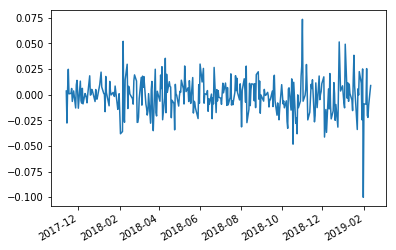

In [51]:
dP.DWDP.plot()

In [52]:
t.DWDP.plot()

NameError: name 't' is not defined

In [70]:
dP_mean = dP.rolling(window=5).mean()
dP_mean.iloc[-5:].mean(axis=1) - dP_mean

**TODO Score the fundamentals and price to rank categories AND rank asset within category - Need 2 scalars**

### Positions

In [14]:
positions

,cost,position,secType,account
symbol,,,,
NVDA,150.100000,10.0,STK,U2728633
FL,56.968824,17.0,STK,U2728633
FB,170.560000,10.0,STK,U2728633
DOW,55.768388,26.0,STK,U2437884
CTVA,24.810000,6.0,STK,U2728633
BABA,166.150000,10.0,STK,U2728633
BABA,160.340000,10.0,STK,U2437884
CTVA,24.810000,26.0,STK,U2437884
MU,34.330000,50.0,STK,U2437884


### Calculate Price differential comparison

In [5]:
P = bars.loc[:, (slice(None), 'close_price')].dropna(axis=1).pct_change().iloc[1:].cumsum(axis=0)
P.columns = P.columns.droplevel(1)
Ps = scaled_price_change(P)

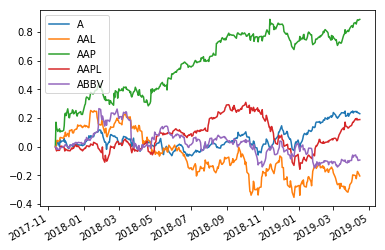

In [18]:
P.iloc[:, :5].plot()

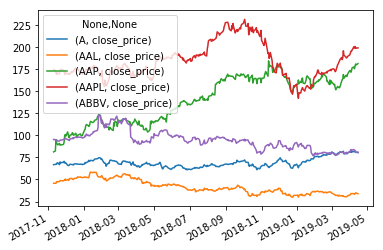

In [24]:
bars.loc[:, (slice(None), 'close_price')].iloc[:, :5].plot()

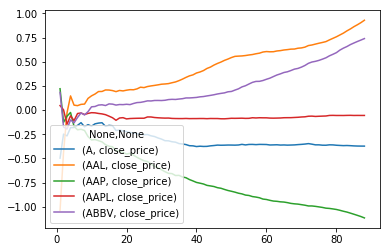

In [29]:
scaled_price_change(bars.loc[:, (slice(None), 'close_price')].iloc[:, :5]).plot()

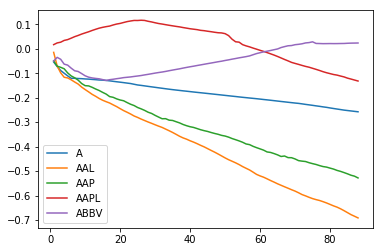

In [28]:
scaled_price_change(P.iloc[:, :5]).plot()

### Calculate the open-close price distribution after accounting for SnP fluctuations

In [43]:
P = bars.loc[:, (slice(None), 'close_price')].dropna(axis=1)
P.columns = P.columns.droplevel(1)
sum_dP = price_calcs.scaled_price_change(P)

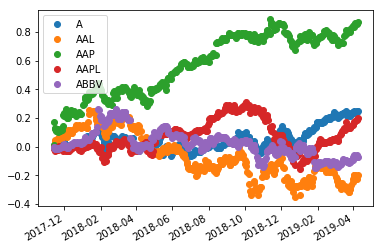

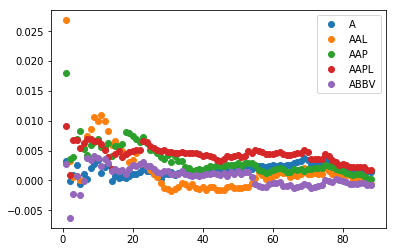

In [46]:
P.pct_change().cumsum().iloc[:, :5].plot(ls="None", marker="o")
sum_dP.iloc[:100, :5].plot(ls="None", marker="o")

2019-04-02    151.01
2019-04-03    151.21
2019-04-04    152.09
2019-04-05    151.89
2019-04-08    153.28
Name: (MKC, close_price), dtype: float64

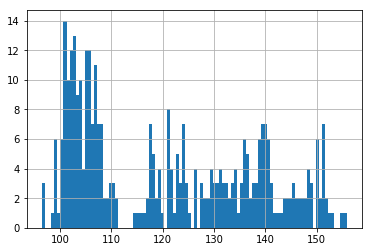

In [26]:
bars.loc[:, ("MKC", "close_price")].hist(bins=100)
bars.loc[:, ("MKC", "close_price")].tail(5)

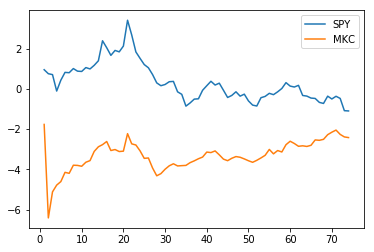

In [26]:
sum_dP[["SPY", "MKC"]].plot()

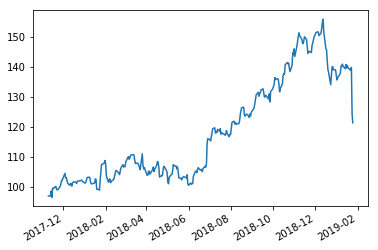

In [27]:
bars.loc[:, ("MKC", "close_price")].plot()

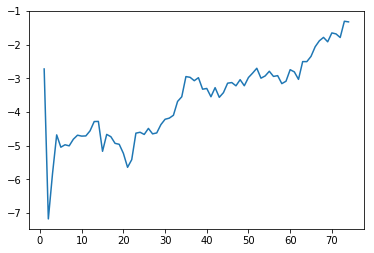

In [11]:
(sum_dP["MKC"] - sum_dP["SPY"]).plot()

In [32]:
fundamentals.columns

Index(['beta', 'bookValuePerShare', 'currentRatio', 'divGrowthRate3Year',
       'dividendAmount', 'dividendDate', 'dividendPayAmount',
       'dividendPayDate', 'dividendYield', 'epsChange', 'epsChangePercentTTM',
       'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'high52',
       'interestCoverage', 'low52', 'ltDebtToEquity', 'marketCap',
       'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM',
       'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
       'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
       'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
       'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
       'shortIntToFloat', 'symbol', 'totalDebtToCapital', 'totalDebtToEquity',
       'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg'],
      dtype='object')

In [33]:
vals = ["dividendYield", "currentRatio", "quickRatio", "peRatio", "pegRatio", "pbRatio", "pcfRatio", "prRatio", "totalDebtToCapital", "totalDebtToEquity"]

In [38]:
fundamentals.loc[["MKC", "CLX", "NVDA", "PFE", "CRM", "ADBE", "C", "JPM", "BAC"], vals]

,dividendYield,currentRatio,quickRatio,peRatio,pegRatio,pbRatio,pcfRatio,prRatio,totalDebtToCapital,totalDebtToEquity
MKC,1.83,0.73932,0.34651,25.6724,0.931193,5.05587,21.4279,2.95536,59.6096,148.109
CLX,2.57,1.0664,0.64615,25.4787,3.95614,27.8375,20.2502,3.04719,79.1178,378.877
NVDA,0.41,7.08085,6.19963,22.0034,0.268008,10.3104,20.3566,7.86439,17.3572,21.0026
PFE,3.52,1.43325,1.15117,16.9482,0.358496,3.29488,11.3503,4.41632,36.4123,57.5409
CRM,0,0.85639,0,111.471,0.125774,7.7963,60.3177,9.14214,23.0088,29.885
ADBE,0,1.12925,0,43.8963,0.675718,12.7592,38.2831,13.2412,30.5837,44.0584
C,2.87,0,0,9.5471,0.408854,0.85319,9.94375,2.14601,0,225.321
JPM,3.11,0,0,11.5039,0.374374,1.46969,11.4769,3.15342,0,208.03
BAC,2.06,0,0,11.333,0.224781,1.17703,13.4939,3.13454,0,164.522


In [49]:
fundamentals.loc[["LRCX", "AMD", "MU", "INTC", "NVDA", "TXN"], vals]

,dividendYield,currentRatio,quickRatio,peRatio,pegRatio,pbRatio,pcfRatio,prRatio,totalDebtToCapital,totalDebtToEquity
LRCX,2.73,3.39474,2.60866,10.172,0.484295,4.40481,8.22373,2.36227,26.2355,35.5666
AMD,0,1.76464,1.37167,0,0,19.4738,0,3.35327,53.6656,115.822
MU,0,2.89825,2.15128,3.2399,0.036204,1.28835,2.22451,1.3865,10.6082,12.2058
INTC,2.41,1.73144,1.2952,0,0,2.87932,0,0,26.1182,35.3513
NVDA,0.41,7.08085,6.19963,22.0034,0.268008,10.3104,20.3566,7.86439,17.3572,21.0026
TXN,3.02,3.27284,2.37672,18.8259,0.365807,10.9721,15.2078,6.2521,36.0404,56.3487


In [38]:
(sum_dP['ADBE'] - sum_dP['QQQ']).plot()

KeyError: 'QQQ'

In [77]:
oc = d_snp.loc[:, (slice(None), 'oc')].subtract(d_indices.loc[:, ('SPY', 'oc')], axis=0, level=1)
cc = d_snp.loc[:, (slice(None), 'cc')].subtract(d_indices.loc[:, ('SPY', 'cc')], axis=0, level=1)
oc.columns=oc.columns.droplevel(1)
cc.columns=c.columns.droplevel(1)

In [85]:
scaled = price_calcs.scaled_price_change(cc)

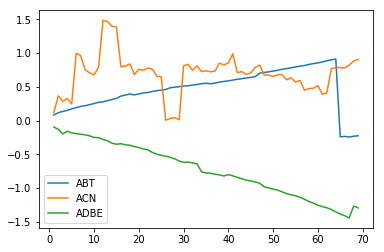

In [90]:
scaled.loc[:, slice("ABT", "ADBE")].plot()

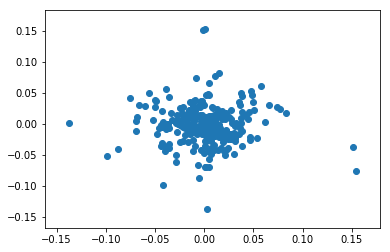

In [84]:
n = 3
k = 4
t = cc.rolling(window=n).sum()
ax = plt.scatter(t.iloc[:-n, k], t.iloc[n:, k])

### Calculate the rolling price change

In [28]:
scaled_dP = price_calcs.scaled_price_change(.loc[:, (slice(None), "close_price")])

In [30]:
scaled_dP.columns.droplevel(1)

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE',
       ...
       'XEL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', name='symbol', length=503)

### Analyze the market over a long time period
Use a long time period to estimate a very long time period *stable* distribution.
Search for what time range is relevant for further analysis. More specifically, looking for a regin that shows relatively constant behavior (stationary distribution).

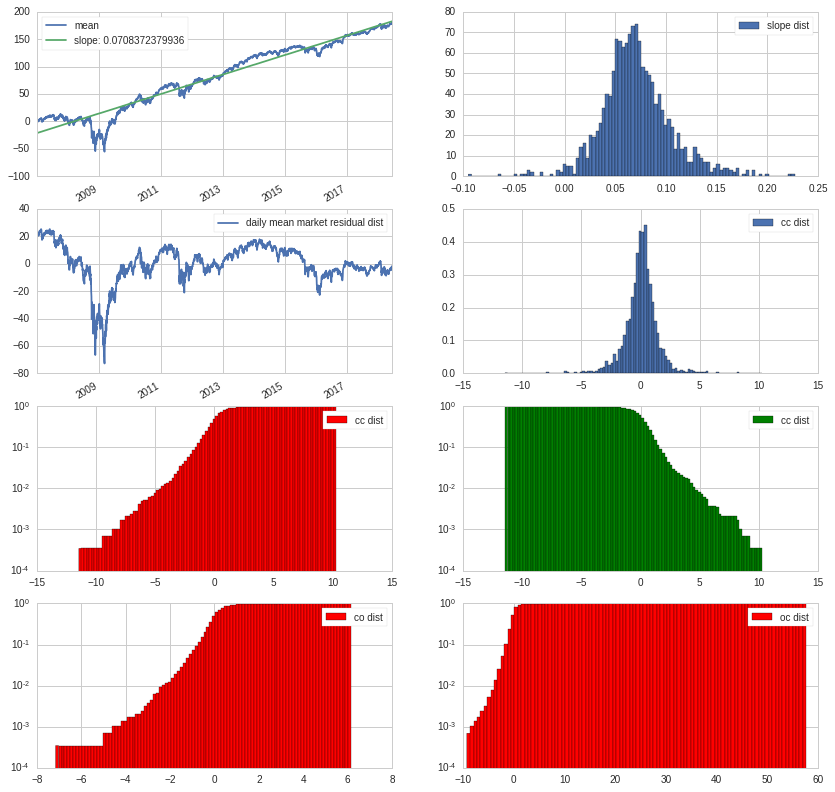

In [31]:
date_range = dbars.major_axis[dbars.major_axis <= pd.Timestamp('2018-07-06')]
dP = 100*dbars.loc[:, date_range, :].drop(symbols(["SPY", "QQQ", "DIA"]), axis=2)
P = dP.loc["cc", :, :].cumsum(axis=0)

t = np.arange(P.shape[0])
regress = P.apply(lambda x: linregress(t, x.values))
slope = regress.apply(lambda x: x[0])

P_model = regress.apply(lambda x: x[0]*t+x[1])
P_model = pd.DataFrame(index=P.index, columns=P.columns, data=np.vstack(tuple([p for p in P_model])).T)
P_res = P - P_model

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,15))
j = P.iloc[:, :].mean(axis=1).plot(ax=ax[0][0], label="mean")
j = P_model.iloc[:, :].mean(axis=1).plot(ax=ax[0][0], label="slope: {}".format(slope.mean()))
ax[0][0].legend(loc="upper left")

j = slope.hist(ax=ax[0][1], bins=100, label="slope dist")
j= ax[0][1].legend()

j = P_res.mean(axis=1).plot(ax=ax[1][0], label="daily mean market residual dist")
j= ax[1][0].legend()

j = dP.loc["cc", :, :].mean(axis=1).hist(ax=ax[1][1], bins=100, log=False, normed=True, label="cc dist")
j= ax[1][1].legend()

j = dP.loc["cc", :, :].mean(axis=1).hist(ax=ax[2][0], bins=100, log=True, color="red", normed=True, cumulative=True, label="cc dist")
j= ax[2][0].legend()

j = dP.loc["cc", :, :].mean(axis=1).hist(ax=ax[2][1], bins=100, log=True, color="green", normed=True, cumulative=-1, label="cc dist")
j= ax[2][1].legend()

j = dP.loc["co", :, :].mean(axis=1).hist(ax=ax[3][0], bins=100, log=True, color="red", normed=True, cumulative=True, label="co dist")
j= ax[3][0].legend()

j = dP.loc["oc", :, :].mean(axis=1).hist(ax=ax[3][1], bins=100, log=True, color="red", normed=True, cumulative=True, label="oc dist")
j= ax[3][1].legend()

### Calculate models for all the assets over a reasonable time frame.
Using the above long term market trajectory. Select a time range to model the current market.

#### Using PCA

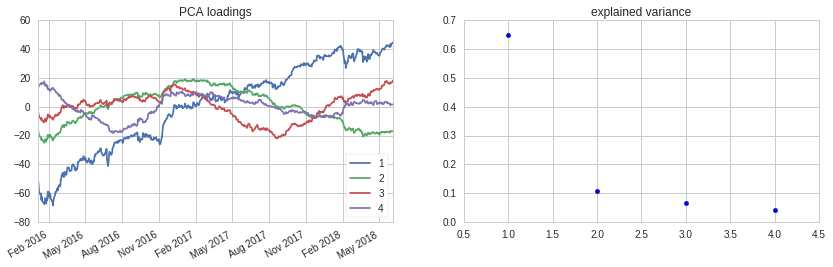

In [32]:
train_date_range = dbars.major_axis[np.logical_and(dbars.major_axis >= pd.Timestamp('2016-01-01'),
                                             dbars.major_axis <= pd.Timestamp('2018-06-05'))]
test_date_range = dbars.major_axis[dbars.major_axis >= pd.Timestamp("2018-06-06")]

dP = 100*dbars.loc[:, train_date_range, :].drop(symbols(["SPY", "QQQ", "DIA"]), axis=2)
P = dP.loc["cc", :, :].cumsum(axis=0)
X = P.apply(lambda x: (x - x.mean()) / x.std())
n_components = 4
pca = PCA(n_components=n_components).fit(X)
loadings = pd.DataFrame(index=P.index, columns=range(1,n_components+1), data=pca.transform(X))
norm_loadings = loadings.apply(lambda x: x/np.sqrt(np.dot(x, x)))
proj = pd.DataFrame(index=range(1, n_components+1), columns=P.columns, data=np.dot(norm_loadings.T.values, P.values))

P_model = pd.DataFrame(index=P.index, columns=P.columns, data=pca.inverse_transform(loadings))
P_model = P_model * (P.std(axis=0)/P_model.std(axis=0)) + P.mean(axis=0)
dP_res = P - P_model
dP_model = P_model[1:] - P_model[:-1]
P_res = dP_res.cumsum(axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
j = loadings.plot(ax=ax[0], title="PCA loadings")

j = ax[1].scatter(np.arange(1, n_components+1), pca.explained_variance_ratio_)
ax[1].set_title("explained variance")

In [33]:
t = proj.loc[:, symbols("LZB")]
t = proj.apply(lambda x: np.sum((x-t)*(x-t)), axis=0)
t = t.sort_values().head().index

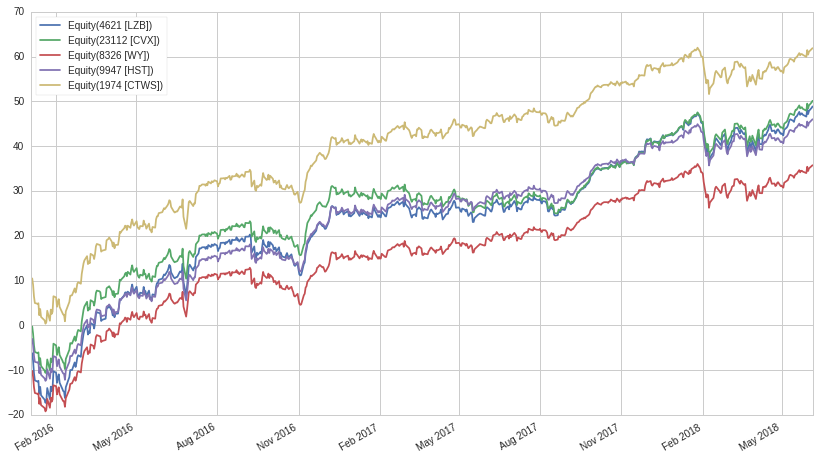

In [34]:
P_model.loc[:, t].plot()

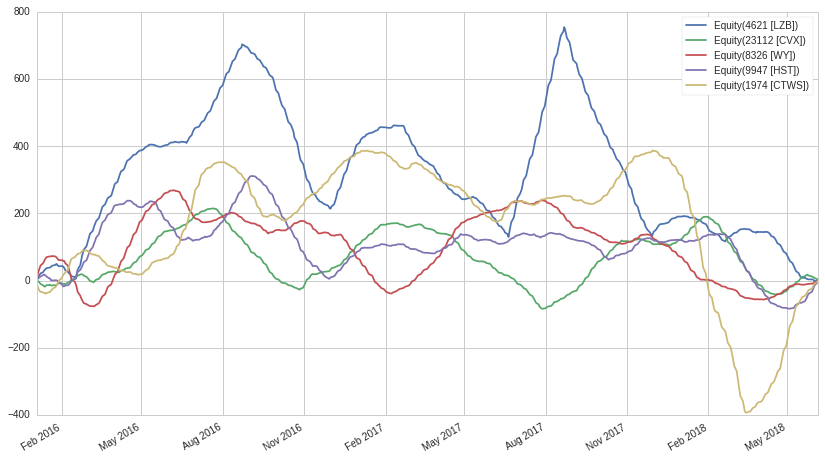

In [35]:
P_res.loc[:, t].plot()

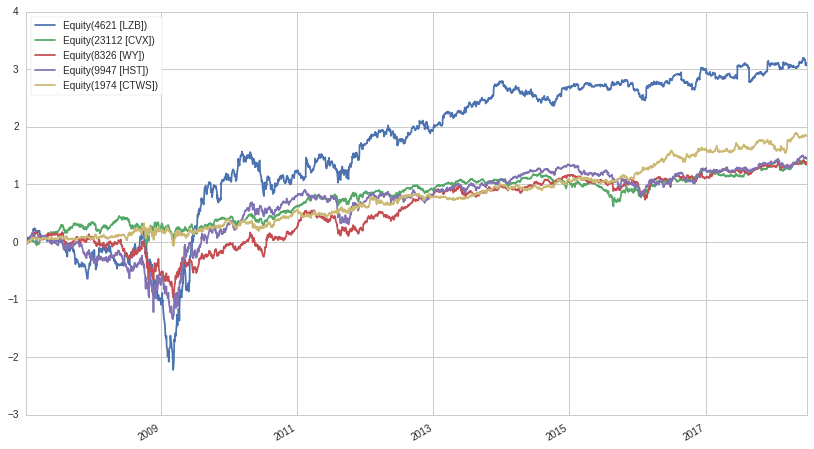

In [36]:
dbars.loc["cc", :, t].cumsum(axis=0).plot()

#### Calculate the linear regression of the model

In [37]:
t = P_model.apply(lambda x: linregress(np.arange(100), x[-100:]))
t = np.concatenate(t.apply(lambda x: [x[0], x[1], x[2], x[3], x[4]]).values).reshape(1432, 5)
P_model_regress = pd.DataFrame(index=["slope", "intercept", "R2", "pval", "std err"], 
                               columns=P_model.columns, data=t.T)

ValueError: total size of new array must be unchanged

In [ ]:
ax = P_model.loc[:, symbols(["DIS", "PG", "MMM", "FDX", "ORCL", "LZB"])].plot()

In [ ]:
ax = P_res.loc[:, symbols(["DIS", "PG", "MMM", "FDX", "ORCL", "LZB"])].plot()

In [ ]:
ax = P_model.loc[:, P_model_regress.loc["slope", :] < -.3].plot()
ax.legend(loc="upper left")

In [ ]:
ax = P_res.loc[:, P_model_regress.loc["slope", :] < -0.3].plot()
ax.legend(loc="upper left")

In [ ]:
criteria = dP_pred >( dP_pred.mean() + dP_pred.std()*2)
assets = dP_pred.loc[criteria].index
print(assets.shape)

fig, ax = plt.subplots(nrows=2, ncols=2)

dbars.loc["cc", test_date_range, criteria.values].mean(axis=0).hist(bins=100, ax=ax[0][0])
dbars.loc["cc", test_date_range, :].mean(axis=0).hist(bins=100, ax=ax[1][0])
ax[0][0].set_xlim(-0.05, .05)
ax[1][0].set_xlim(-0.05, .05)

ax[0][1].scatter(dP_pred, dbars.drop(symbols(["SPY", "QQQ", "DIA"]), axis=2).loc["cc", test_date_range, :].mean(axis=0))
print(linregress(dP_pred, dbars.drop(symbols(["SPY", "QQQ", "DIA"]), axis=2).loc["cc", test_date_range, :].mean(axis=0)))

sub_assets = assets[16:20]
P_model.loc[:, sub_assets].plot(ax=ax[1][1], colormap=cm.jet, ls=":")
P.loc[:, sub_assets].plot(ax=ax[1][1], colormap=cm.jet)
ax[1][1].legend(loc="lower left")

In [ ]:
train_date_range = dbars.major_axis[np.logical_and(dbars.major_axis >= pd.Timestamp('2017-01-01'),
                                             dbars.major_axis <= pd.Timestamp('2018-06-05'))]
test_date_range = dbars.major_axis[dbars.major_axis >= pd.Timestamp("2018-06-06")]

V = bars["volume", train_date_range, :].drop(symbols(["SPY", "QQQ", "DIA"]), axis=1)
X = V.apply(lambda x: (x - x.mean()) / x.std())
n_components = 4
pca = PCA(n_components=n_components).fit(X)
loadings = pd.DataFrame(index=V.index, columns=range(1,n_components+1), data=pca.transform(X))
norm_loadings = loadings.apply(lambda x: x/np.sqrt(np.dot(x, x)))
proj = pd.DataFrame(index=range(1, n_components+1), columns=V.columns, data=np.dot(norm_loadings.T.values, V.values))

V_model = pd.DataFrame(index=V.index, columns=V.columns, data=pca.inverse_transform(loadings))
V_model = V_model * (V.std(axis=0)/V_model.std(axis=0)) + V.mean(axis=0)
V_model_mean = V_model.mean(axis=1)
V_res = V.apply(lambda x: x - V_model_mean)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
j = loadings.plot(ax=ax[0], title="PCA loadings")

j = ax[1].scatter(np.arange(1, n_components+1), pca.explained_variance_ratio_)
ax[1].set_title("explained variance")

In [ ]:
train_date_range = dbars.major_axis[np.logical_and(dbars.major_axis >= pd.Timestamp('2017-01-01'),
                                             dbars.major_axis <= pd.Timestamp('2018-06-05'))]
test_date_range = dbars.major_axis[dbars.major_axis >= pd.Timestamp("2018-06-06")]

dP = 100*dbars.loc[:, train_date_range, :].drop(symbols(["SPY", "QQQ", "DIA"]), axis=2)
P = dP.loc["cc", :, :].cumsum(axis=0)
X = P.apply(lambda x: (x - x.mean()) / x.std())
n_components = 4
pca = PCA(n_components=n_components).fit(X)
loadings = pd.DataFrame(index=P.index, columns=range(1,n_components+1), data=pca.transform(X))
norm_loadings = loadings.apply(lambda x: x/np.sqrt(np.dot(x, x)))
proj = pd.DataFrame(index=range(1, n_components+1), columns=P.columns, data=np.dot(norm_loadings.T.values, P.values))

P_model = pd.DataFrame(index=P.index, columns=P.columns, data=pca.inverse_transform(loadings))
P_model = P_model * (P.std(axis=0)/P_model.std(axis=0)) + P.mean(axis=0)
P_model_mean = P_model.mean(axis=1)
P_res = P.apply(lambda x: x - P_model_mean)

P_model_slope = P_model.apply(lambda x: linregress(np.arange(100), x[-100:])[0])
P_res_slope = P_model.apply(lambda x: linregress(np.arange(30), x[-30:])[0])
P_res_end = P_res.iloc[-5:].mean()
#This was the best so far (2018-06-14)
#dP_pred = P_model_slope + P_res_slope - 1*P_res_end 
dP_pred = -P_res_end

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
j = loadings.plot(ax=ax[0], title="PCA loadings")

j = ax[1].scatter(np.arange(1, n_components+1), pca.explained_variance_ratio_)
ax[1].set_title("explained variance")